# Analyzing Statute-Barred Status for Financial Records

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

In [2]:
d={"name":["abc","def","ghi"],
  "age":[25],
  "salary":[25000]}

In [5]:
import pandas as pd
dt=pd.DataFrame(d,index=[0, 1, 2])

In [6]:
dt

,name,age,salary
0,abc,25,25000
1,def,25,25000
2,ghi,25,25000


## Importing the data

In [2]:
data=pd.read_excel('Company_x.xlsx')

In [3]:
# Shape of data
data.shape

(406423, 25)

In [4]:
data.head()

,EntityID,OriginalCreditor[Redacted],AccountID,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,ClosureReason,...,LastPaymentMethod,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,932,Creditor 1,3677,0.0,1160.20,1160.20,4.22,Other,PAID_IN_FULL,NaN,...,Cheque,1.0,53.0,0,0,1,N,NaN,NaN,NaN
1,160,Creditor 2,4276,182.9,182.90,182.90,4.22,Other,CANCELLED_WITHDRAWN,NaN,...,NaN,1.0,NaN,0,0,1,Y,NaN,NaN,NaN
2,932,Creditor 1,8525,0.0,538.57,538.57,4.22,Other,PAID_IN_FULL,NaN,...,Cheque,1.0,NaN,1,0,1,N,NaN,NaN,NaN
3,160,Creditor 2,9859,8279.5,8279.50,8279.50,4.22,Other,PASSIVE,NaN,...,NaN,1.0,NaN,1,0,1,Y,NaN,NaN,NaN
4,932,Creditor 1,12807,0.0,523.00,523.00,4.22,Other,PAID_IN_FULL,NaN,...,Cheque,1.0,46.0,2,0,1,Y,NaN,NaN,NaN


In [5]:
data.tail()

,EntityID,OriginalCreditor[Redacted],AccountID,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,ClosureReason,...,LastPaymentMethod,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,Unnamed: 22,Unnamed: 23,Unnamed: 24
406418,99901565,Creditor 50,990495842,448.20,448.20,448.20,7.38,Finance Company - Other,ACTIVE,NaN,...,NaN,1.0,36.0,1,1,1,N,NaN,NaN,NaN
406419,99901565,Creditor 50,990495843,1678.37,1678.37,1678.37,7.38,Finance Company - Other,ACTIVE,NaN,...,NaN,1.0,37.0,0,1,1,N,NaN,NaN,NaN
406420,99901565,Creditor 50,990495844,3512.60,3512.60,3512.60,7.38,Finance Company - Other,ACTIVE,NaN,...,NaN,1.0,71.0,1,1,1,N,NaN,NaN,NaN
406421,99901565,Creditor 50,990495845,4477.31,4477.31,4477.31,7.38,Finance Company - Other,ACTIVE,NaN,...,NaN,1.0,38.0,1,1,1,N,NaN,NaN,NaN
406422,99901565,Creditor 50,990495846,272.59,272.59,272.59,7.38,Finance Company - Other,ACTIVE,NaN,...,NaN,1.0,30.0,0,1,1,N,NaN,NaN,NaN


In [3]:
# Dropping the extra columns
data=data.iloc[:,0:22]
print(data.shape)

(406423, 22)


In [7]:
# Creating a copy of the data
first_copy=data.copy()
first_copy.shape

(406423, 22)

In [8]:
# Checking for duplicate rows
first_copy.duplicated().sum()

0

In [9]:
# General information about the data
first_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406423 entries, 0 to 406422
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   EntityID                    406423 non-null  int64  
 1   OriginalCreditor[Redacted]  406423 non-null  object 
 2   AccountID                   406423 non-null  int64  
 3   CurrentBalance              406423 non-null  float64
 4   DebtLoadPrincipal           406423 non-null  float64
 5   Balanaceatdebt_load         406423 non-null  float64
 6   PurchasePrice               403731 non-null  float64
 7   ProductOrDebtType           406423 non-null  object 
 8   CollectionStatus            406423 non-null  object 
 9   ClosureReason               9030 non-null    object 
 10  InBankruptcy                406423 non-null  object 
 11  AccountInsolvencyType       285 non-null     object 
 12  CustomerInsolvencyType      8531 non-null    object 
 13  IsLegal       

In [10]:
# By looking at the data,we can see that 'AccountID' and 'EntityID'
# are merely numbers associated with the account and lending institute,
# (just like indexes,row nos.).Thus they are logically irrelevant columns 
# and hence dropping them
first_copy.drop(['EntityID', 'AccountID'], axis=1, inplace=True)

In [11]:
print(first_copy.shape)
print("\n")
first_copy.head(3)

(406423, 20)




,OriginalCreditor[Redacted],CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,ClosureReason,InBankruptcy,AccountInsolvencyType,CustomerInsolvencyType,IsLegal,LastPaymentAmount,LastPaymentMethod,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred
0,Creditor 1,0.0,1160.20,1160.20,4.22,Other,PAID_IN_FULL,NaN,N,NaN,NaN,Y,10.00,Cheque,1.0,53.0,0,0,1,N
1,Creditor 2,182.9,182.90,182.90,4.22,Other,CANCELLED_WITHDRAWN,NaN,N,NaN,NaN,N,NaN,NaN,1.0,NaN,0,0,1,Y
2,Creditor 1,0.0,538.57,538.57,4.22,Other,PAID_IN_FULL,NaN,N,NaN,NaN,N,5.37,Cheque,1.0,NaN,1,0,1,N


In [12]:
first_copy.tail(3)

,OriginalCreditor[Redacted],CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,ClosureReason,InBankruptcy,AccountInsolvencyType,CustomerInsolvencyType,IsLegal,LastPaymentAmount,LastPaymentMethod,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred
406420,Creditor 50,3512.60,3512.60,3512.60,7.38,Finance Company - Other,ACTIVE,NaN,N,NaN,NaN,N,NaN,NaN,1.0,71.0,1,1,1,N
406421,Creditor 50,4477.31,4477.31,4477.31,7.38,Finance Company - Other,ACTIVE,NaN,N,NaN,NaN,N,NaN,NaN,1.0,38.0,1,1,1,N
406422,Creditor 50,272.59,272.59,272.59,7.38,Finance Company - Other,ACTIVE,NaN,N,NaN,NaN,N,NaN,NaN,1.0,30.0,0,1,1,N


In [153]:
# Segregating numerical and categorical features as a list
numerical_features=['CurrentBalance','DebtLoadPrincipal',
                   'Balanaceatdebt_load','PurchasePrice',
                   'NumLiableParties','CustomerAge','NumPhones',
                   'NumEmails','NumAddresses','LastPaymentAmount']
categorical_features=['OriginalCreditor[Redacted]','ProductOrDebtType',
                     'CollectionStatus','InBankruptcy','IsLegal',
                     'AccountInsolvencyType','CustomerInsolvencyType',
                     'ClosureReason','LastPaymentMethod']

## Visualizing the data

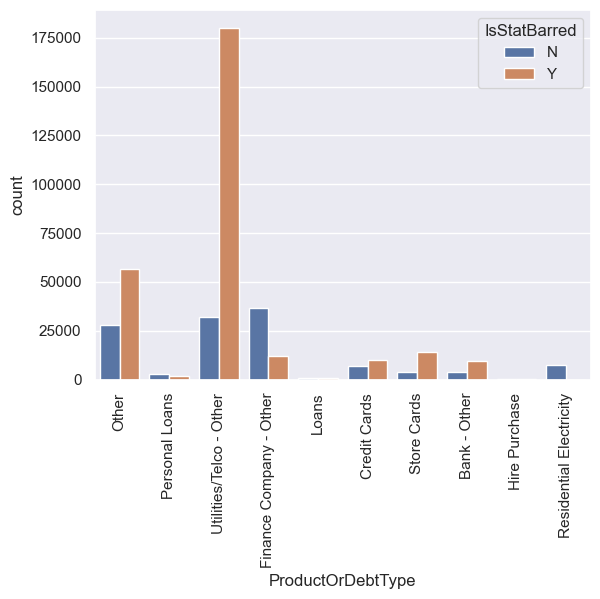

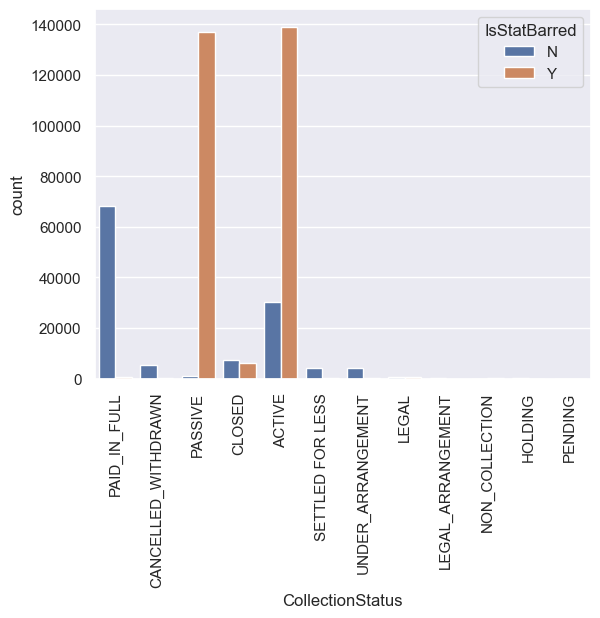

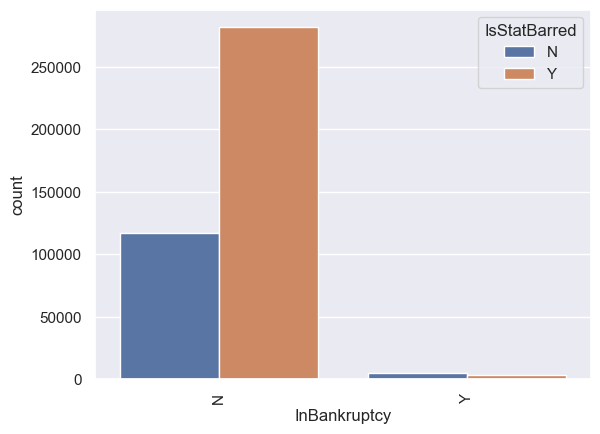

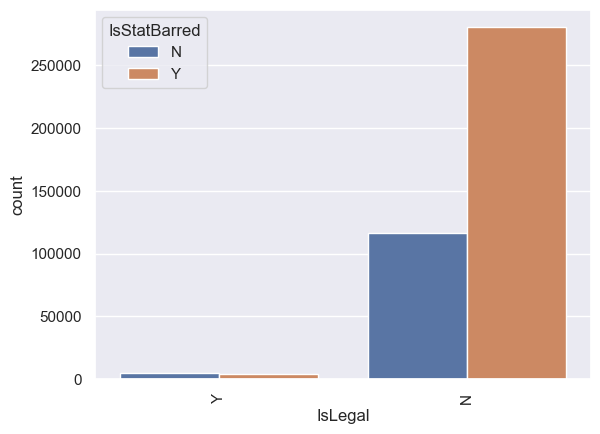

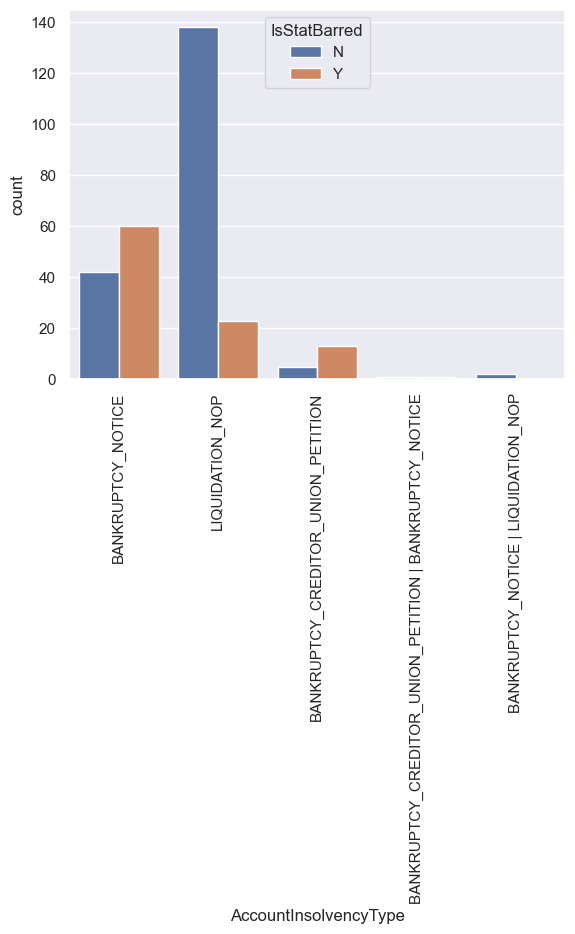

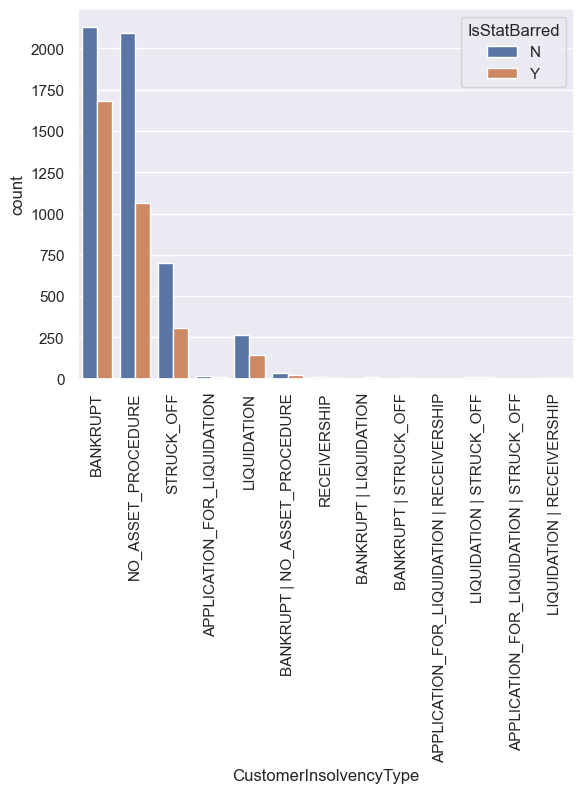

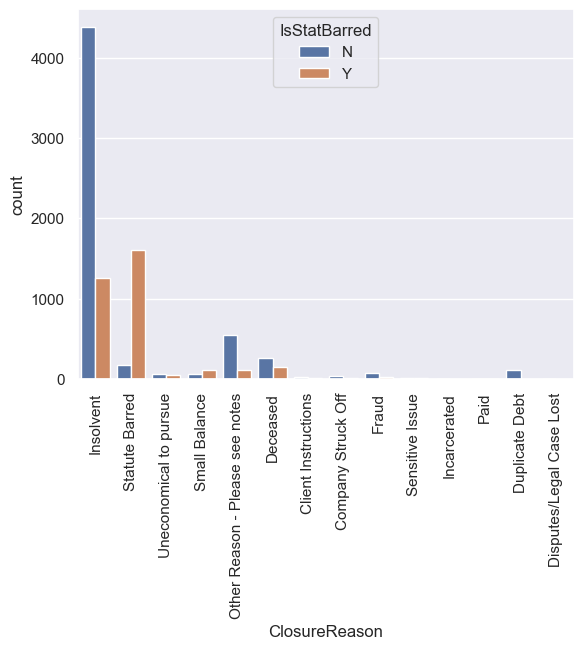

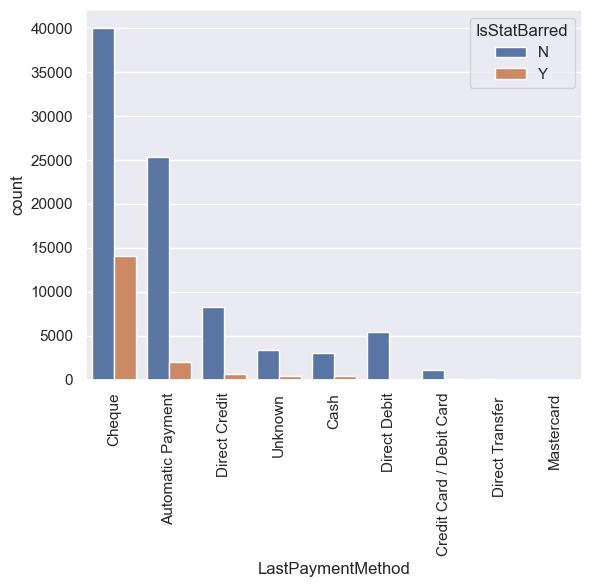

In [171]:
# Boxplots for outliers is shown down the lane
# Countplots
for i in range(1,9):
    sns.countplot(x=categorical_features[i],data=data,hue="IsStatBarred")
    plt.xticks(rotation=90)
    plt.show()
    

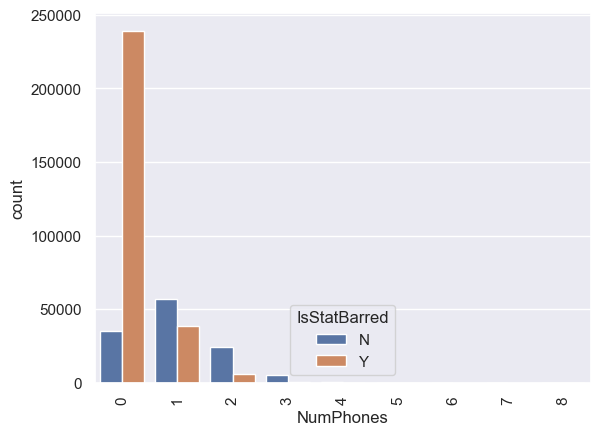

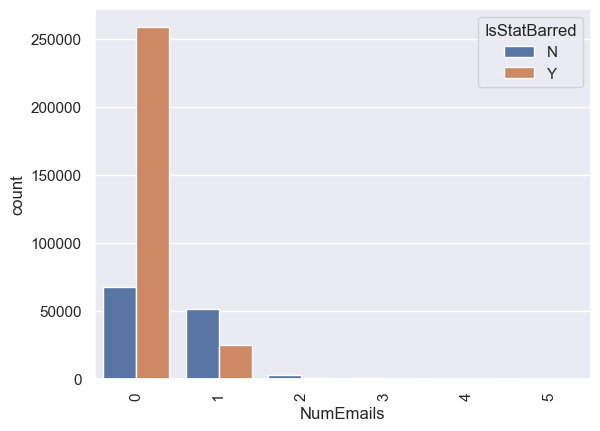

In [166]:
sns.countplot(x='NumPhones',data=data,hue="IsStatBarred")
plt.xticks(rotation=90)
plt.show()
sns.countplot(x='NumEmails',data=data,hue="IsStatBarred")
plt.xticks(rotation=90)
plt.show()

#### From the count plots it is evident that some features possess high cardinality,as well as the proportionate of some of the sub categories in some features are  extremely low .Hence internal binding is required.

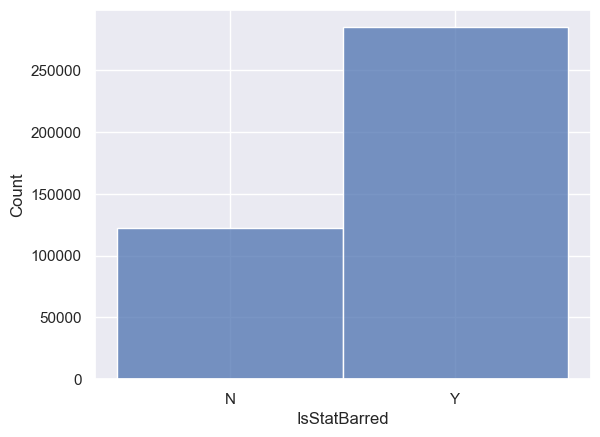

In [11]:
sns.histplot(x=data['IsStatBarred'])
plt.show()

#### The dependent variable seems to exhibit class imbalance.This should be taken care.

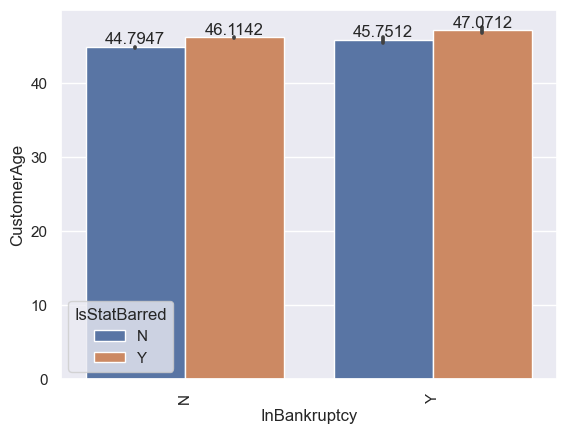

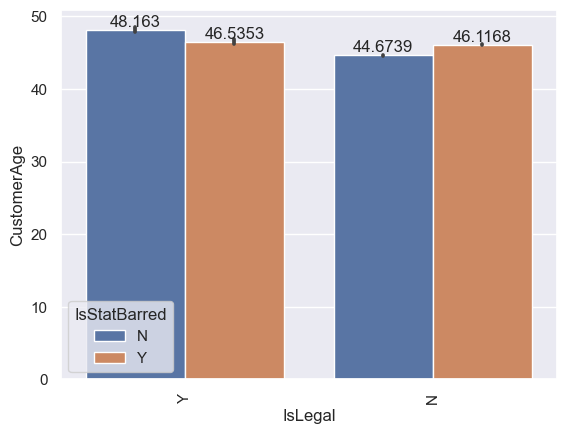

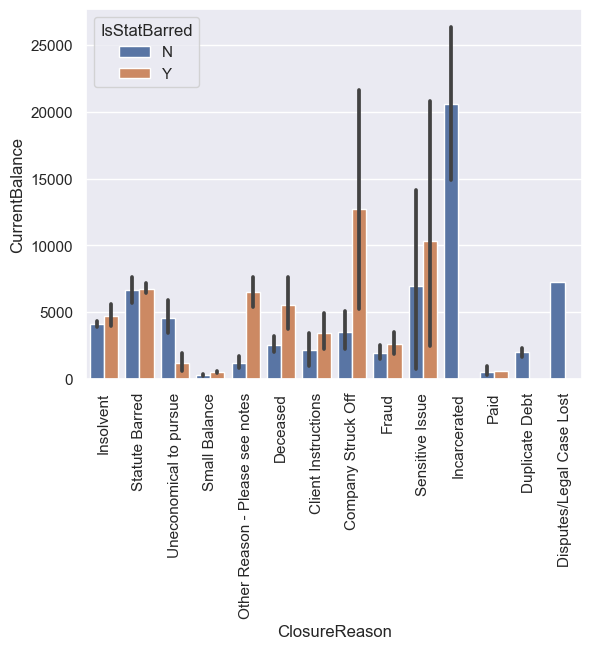

In [10]:
# some additional plots 
ax=sns.barplot(y=data['CustomerAge'],
            x=data['InBankruptcy'],
           hue=data['IsStatBarred'])
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation=90)
plt.show()

ax=sns.barplot(y=data['CustomerAge'],
            x=data['IsLegal'],
           hue=data['IsStatBarred'])
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation=90)
plt.show()

ax=sns.barplot(y=data['CurrentBalance'],
            x=data['ClosureReason'],
           hue=data['IsStatBarred'])
plt.xticks(rotation=90)
plt.show()

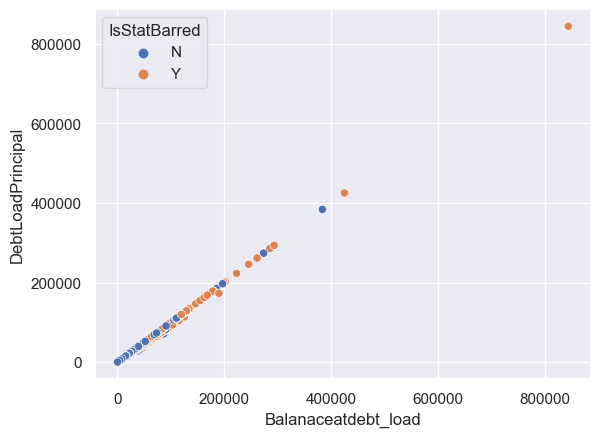

In [13]:
sns.scatterplot(data=data,x='Balanaceatdebt_load',y='DebtLoadPrincipal',
               hue='IsStatBarred')
plt.show()

## Handling missing values

In [13]:
# Looking for null values 
first_copy.isnull().sum()

OriginalCreditor[Redacted]         0
CurrentBalance                     0
DebtLoadPrincipal                  0
Balanaceatdebt_load                0
PurchasePrice                   2692
ProductOrDebtType                  0
CollectionStatus                   0
ClosureReason                 397393
InBankruptcy                       0
AccountInsolvencyType         406138
CustomerInsolvencyType        397892
IsLegal                            0
LastPaymentAmount             302446
LastPaymentMethod             302446
NumLiableParties                 122
CustomerAge                    29482
NumPhones                          0
NumEmails                          0
NumAddresses                       0
IsStatBarred                       0
dtype: int64

In [14]:
# Null values as a percentage of total
(first_copy.isnull().sum()/len(first_copy))*100

OriginalCreditor[Redacted]     0.000000
CurrentBalance                 0.000000
DebtLoadPrincipal              0.000000
Balanaceatdebt_load            0.000000
PurchasePrice                  0.662364
ProductOrDebtType              0.000000
CollectionStatus               0.000000
ClosureReason                 97.778177
InBankruptcy                   0.000000
AccountInsolvencyType         99.929876
CustomerInsolvencyType        97.900955
IsLegal                        0.000000
LastPaymentAmount             74.416556
LastPaymentMethod             74.416556
NumLiableParties               0.030018
CustomerAge                    7.254019
NumPhones                      0.000000
NumEmails                      0.000000
NumAddresses                   0.000000
IsStatBarred                   0.000000
dtype: float64

In [15]:
# Generally,as a rule of thumb,we discard columns having missing values
# greater than 25%,provided we get concurrence from sme or client as 
# sometimes the missing values are provided or given guidance to imupte 
# accordingly.Here i am dropping those columns where missing % is 
# more than 25

first_copy.drop(['ClosureReason', 'AccountInsolvencyType','CustomerInsolvencyType','LastPaymentAmount','LastPaymentMethod'], axis=1, inplace=True)

In [16]:
print(first_copy.shape)
first_copy.head(2)

(406423, 15)


,OriginalCreditor[Redacted],CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,InBankruptcy,IsLegal,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred
0,Creditor 1,0.0,1160.2,1160.2,4.22,Other,PAID_IN_FULL,N,Y,1.0,53.0,0,0,1,N
1,Creditor 2,182.9,182.9,182.9,4.22,Other,CANCELLED_WITHDRAWN,N,N,1.0,NaN,0,0,1,Y


In [17]:
first_copy.tail(2)

,OriginalCreditor[Redacted],CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,InBankruptcy,IsLegal,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred
406421,Creditor 50,4477.31,4477.31,4477.31,7.38,Finance Company - Other,ACTIVE,N,N,1.0,38.0,1,1,1,N
406422,Creditor 50,272.59,272.59,272.59,7.38,Finance Company - Other,ACTIVE,N,N,1.0,30.0,0,1,1,N


In [18]:
first_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406423 entries, 0 to 406422
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   OriginalCreditor[Redacted]  406423 non-null  object 
 1   CurrentBalance              406423 non-null  float64
 2   DebtLoadPrincipal           406423 non-null  float64
 3   Balanaceatdebt_load         406423 non-null  float64
 4   PurchasePrice               403731 non-null  float64
 5   ProductOrDebtType           406423 non-null  object 
 6   CollectionStatus            406423 non-null  object 
 7   InBankruptcy                406423 non-null  object 
 8   IsLegal                     406423 non-null  object 
 9   NumLiableParties            406301 non-null  float64
 10  CustomerAge                 376941 non-null  float64
 11  NumPhones                   406423 non-null  int64  
 12  NumEmails                   406423 non-null  int64  
 13  NumAddresses  

In [19]:
(first_copy.isnull().sum()/len(first_copy))*100

OriginalCreditor[Redacted]    0.000000
CurrentBalance                0.000000
DebtLoadPrincipal             0.000000
Balanaceatdebt_load           0.000000
PurchasePrice                 0.662364
ProductOrDebtType             0.000000
CollectionStatus              0.000000
InBankruptcy                  0.000000
IsLegal                       0.000000
NumLiableParties              0.030018
CustomerAge                   7.254019
NumPhones                     0.000000
NumEmails                     0.000000
NumAddresses                  0.000000
IsStatBarred                  0.000000
dtype: float64

In [21]:
# printing out the unique values in each column
for i in first_copy.columns:
    print(i," : ",first_copy[i].nunique())

OriginalCreditor[Redacted]  :  52
CurrentBalance  :  177653
DebtLoadPrincipal  :  195921
Balanaceatdebt_load  :  198413
PurchasePrice  :  48
ProductOrDebtType  :  10
CollectionStatus  :  12
InBankruptcy  :  2
IsLegal  :  2
NumLiableParties  :  4
CustomerAge  :  126
NumPhones  :  9
NumEmails  :  6
NumAddresses  :  8
IsStatBarred  :  2


In [22]:
print(first_copy['NumLiableParties'].value_counts())
print("\n")
print((first_copy['NumLiableParties'].value_counts())/len(first_copy)*100)

1.0    399494
2.0      6652
3.0       151
4.0         4
Name: NumLiableParties, dtype: int64


1.0    98.295126
2.0     1.636718
3.0     0.037153
4.0     0.000984
Name: NumLiableParties, dtype: float64


In [23]:
# 'NumLiableParties' column has got only 4 unique discrete values and 
# labelled as numeric.It will be treated as categorical.
# Of those 4 values 2 values contributes to only 0.038% of the enitre
# dataset.Hence binding them to avoid unnecessary zeros while encoding.
#0.037153+0.000984 =0.038137

first_copy.NumLiableParties.replace({3.0:2.0,4.0:2.0},inplace=True)
print(first_copy['NumLiableParties'].value_counts())
print("\n")
print((first_copy['NumLiableParties'].value_counts())/len(first_copy)*100)

1.0    399494
2.0      6807
Name: NumLiableParties, dtype: int64


1.0    98.295126
2.0     1.674856
Name: NumLiableParties, dtype: float64


In [24]:
# Filling missing values in 'NumLiableParties'
first_copy['NumLiableParties']=first_copy['NumLiableParties'].fillna(first_copy['NumLiableParties'].mode()[0])

In [25]:
first_copy['NumLiableParties'].isnull().sum()

0

In [26]:
print(first_copy['PurchasePrice'].value_counts())
print("\n")
print(first_copy['PurchasePrice'].nunique())

3.07     84764
2.32     39909
3.60     38075
7.38     34214
4.22     32402
5.72     24862
4.96     18870
6.59     17250
11.70    16655
4.31     16575
9.68     14477
5.34      8523
3.87      8449
9.41      8048
3.96      6536
8.15      4493
52.18     3783
15.31     3521
4.23      3373
1.84      2762
5.11      2281
10.95     1733
14.83     1542
6.31      1449
1.44      1327
25.41     1158
7.74       921
10.30      874
0.19       855
6.93       785
10.75      633
6.08       542
5.00       474
16.70      434
1.77       355
0.65       310
32.27      246
11.07      152
2.35       106
12.00        3
11.67        2
11.71        2
11.73        1
11.10        1
4.00         1
15.00        1
4.97         1
7.00         1
Name: PurchasePrice, dtype: int64


48


<AxesSubplot:ylabel='PurchasePrice'>

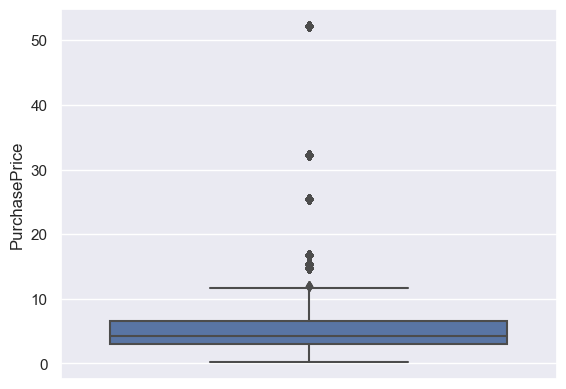

In [27]:
# 'PurchasePrice' column has got a lot of unique values and these are not 
# discrete.Hence treating it as numeric. Plotting the box plot to find
# any outliers present or not
sns.boxplot(y=first_copy['PurchasePrice'])

In [28]:
# outliers present,hence going with ,median imputation
first_copy['PurchasePrice']=first_copy['PurchasePrice'].fillna(first_copy['PurchasePrice'].median())

In [29]:
first_copy['PurchasePrice'].isnull().sum()

0

In [30]:
print(first_copy['CustomerAge'].value_counts())
print("\n")
print(first_copy['CustomerAge'].nunique())

 38.0    14260
 37.0    13788
 39.0    13335
 36.0    12765
 40.0    12662
         ...  
 5.0         1
-6.0         1
-22.0        1
-4.0         1
-30.0        1
Name: CustomerAge, Length: 126, dtype: int64


126


In [31]:
# some of the age is negative which is practically impossible,hence
# converting them to positive numbers
first_copy['CustomerAge']=np.where(first_copy['CustomerAge']<0,
                                  first_copy['CustomerAge']*-1,
                                  first_copy['CustomerAge'])

In [32]:
len(first_copy[first_copy['CustomerAge']<0])

0

In [33]:
first_copy['CustomerAge'].describe()

count    376941.000000
mean         45.730273
std          12.942580
min           1.000000
25%          36.000000
50%          44.000000
75%          54.000000
max         133.000000
Name: CustomerAge, dtype: float64

In [34]:
# Maximum and minimum ages are 133 and 1 respectively,again practically 
# impossible .Allmost all of the lending institutes lend money to customers
# in the age bracket 18-85 with a few exception such as student debt.
# Hence ceiling the age values in the bracket 16-85
first_copy['CustomerAge']=np.where(first_copy['CustomerAge']>85,
                                  85,first_copy['CustomerAge'])
first_copy['CustomerAge']=np.where(first_copy['CustomerAge']<16,
                                  16,first_copy['CustomerAge'])                        

In [35]:
first_copy['CustomerAge'].describe()

count    376941.000000
mean         45.680613
std          12.762897
min          16.000000
25%          36.000000
50%          44.000000
75%          54.000000
max          85.000000
Name: CustomerAge, dtype: float64

<AxesSubplot:ylabel='CustomerAge'>

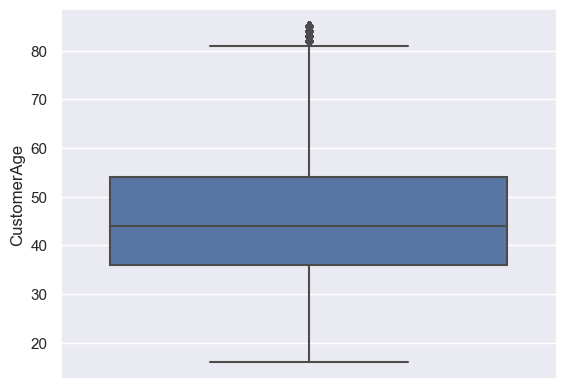

In [36]:
sns.boxplot(y=first_copy['CustomerAge'])

In [37]:
# outliers present,hence going with ,median imputation
first_copy['CustomerAge']=first_copy['CustomerAge'].fillna(first_copy['CustomerAge'].median())
first_copy['PurchasePrice'].isnull().sum()

0

In [38]:
# Missing values are handled
first_copy.isnull().sum()

OriginalCreditor[Redacted]    0
CurrentBalance                0
DebtLoadPrincipal             0
Balanaceatdebt_load           0
PurchasePrice                 0
ProductOrDebtType             0
CollectionStatus              0
InBankruptcy                  0
IsLegal                       0
NumLiableParties              0
CustomerAge                   0
NumPhones                     0
NumEmails                     0
NumAddresses                  0
IsStatBarred                  0
dtype: int64

In [39]:
# For future reference
second_copy=first_copy.copy()

## Encoding

In [40]:
print(first_copy['ProductOrDebtType'].nunique())
print("\n")
print(first_copy['ProductOrDebtType'].value_counts())
print("\n")
print((first_copy['ProductOrDebtType'].value_counts()/len(first_copy))*100)

10


Utilities/Telco - Other    212158
Other                       84218
Finance Company - Other     48695
Store Cards                 17699
Credit Cards                16891
Bank - Other                13030
Residential Electricity      7693
Personal Loans               4309
Loans                        1260
Hire Purchase                 470
Name: ProductOrDebtType, dtype: int64


Utilities/Telco - Other    52.201278
Other                      20.721760
Finance Company - Other    11.981359
Store Cards                 4.354822
Credit Cards                4.156015
Bank - Other                3.206019
Residential Electricity     1.892855
Personal Loans              1.060225
Loans                       0.310022
Hire Purchase               0.115643
Name: ProductOrDebtType, dtype: float64


In [41]:
# In 'ProductOrDebtType' column,the individual contributions of some
# categories are extremely low compared to others.hence it is good to bind 
# logically.

first_copy.ProductOrDebtType.replace(
    {'Residential Electricity':'Bank - Other',
     'Personal Loans':'Bank - Other',
     'Loans':'Bank - Other',
     'Hire Purchase':'Bank - Other',
     "Store Cards":"Credit Cards"
     },inplace=True)

In [42]:
print(first_copy['ProductOrDebtType'].nunique())
print("\n")
print(first_copy['ProductOrDebtType'].value_counts())
print("\n")
print((first_copy['ProductOrDebtType'].value_counts()/len(first_copy))*100)

5


Utilities/Telco - Other    212158
Other                       84218
Finance Company - Other     48695
Credit Cards                34590
Bank - Other                26762
Name: ProductOrDebtType, dtype: int64


Utilities/Telco - Other    52.201278
Other                      20.721760
Finance Company - Other    11.981359
Credit Cards                8.510837
Bank - Other                6.584765
Name: ProductOrDebtType, dtype: float64


In [43]:
print(first_copy['CollectionStatus'].nunique())
print("\n")
print(first_copy['CollectionStatus'].value_counts())
print("\n")
print((first_copy['CollectionStatus'].value_counts()/len(first_copy))*100)

12


ACTIVE                 169489
PASSIVE                138040
PAID_IN_FULL            69172
CLOSED                  13562
CANCELLED_WITHDRAWN      5489
UNDER_ARRANGEMENT        4237
SETTLED FOR LESS         4191
LEGAL                    1559
LEGAL_ARRANGEMENT         361
NON_COLLECTION            237
HOLDING                    59
PENDING                    27
Name: CollectionStatus, dtype: int64


ACTIVE                 41.702610
PASSIVE                33.964613
PAID_IN_FULL           17.019706
CLOSED                  3.336917
CANCELLED_WITHDRAWN     1.350563
UNDER_ARRANGEMENT       1.042510
SETTLED FOR LESS        1.031192
LEGAL                   0.383590
LEGAL_ARRANGEMENT       0.088824
NON_COLLECTION          0.058314
HOLDING                 0.014517
PENDING                 0.006643
Name: CollectionStatus, dtype: float64


In [44]:
# In 'CollectionStatus' column,the individual contributions of some
# categories are extremely low compared to others.hence it is good to bind 
# logically.

first_copy.CollectionStatus.replace(
    {'PENDING':'PASSIVE',
     'HOLDING':'PASSIVE',
     'LEGAL':'PASSIVE',
     'LEGAL_ARRANGEMENT':'PASSIVE',
     "CANCELLED_WITHDRAWN":"CLOSED",
     "NON_COLLECTION":"CLOSED"
     },inplace=True)

In [45]:
print(first_copy['CollectionStatus'].nunique())
print("\n")
print(first_copy['CollectionStatus'].value_counts())
print("\n")
print((first_copy['CollectionStatus'].value_counts()/len(first_copy))*100)

6


ACTIVE               169489
PASSIVE              140046
PAID_IN_FULL          69172
CLOSED                19288
UNDER_ARRANGEMENT      4237
SETTLED FOR LESS       4191
Name: CollectionStatus, dtype: int64


ACTIVE               41.702610
PASSIVE              34.458188
PAID_IN_FULL         17.019706
CLOSED                4.745794
UNDER_ARRANGEMENT     1.042510
SETTLED FOR LESS      1.031192
Name: CollectionStatus, dtype: float64


In [46]:
print(first_copy['NumPhones'].nunique())
print("\n")
print(first_copy['NumPhones'].value_counts())
print("\n")
print((first_copy['NumPhones'].value_counts()/len(first_copy))*100)

9


0    274161
1     95361
2     29974
3      6141
4       633
5       128
6        22
8         2
7         1
Name: NumPhones, dtype: int64


0    67.457058
1    23.463485
2     7.375075
3     1.510987
4     0.155749
5     0.031494
6     0.005413
8     0.000492
7     0.000246
Name: NumPhones, dtype: float64


In [47]:
# In 'NumPhones' column,the individual contributions of some
# categories are extremely low compared to others.hence binding
# few categories where the frequency is poor

first_copy.NumPhones.replace(
    {4:3,
     5:3,
     6:3,
     7:3,
     8:3
     },inplace=True)

In [48]:
print(first_copy['NumPhones'].nunique())
print("\n")
print(first_copy['NumPhones'].value_counts())
print("\n")
print((first_copy['NumPhones'].value_counts()/len(first_copy))*100)

4


0    274161
1     95361
2     29974
3      6927
Name: NumPhones, dtype: int64


0    67.457058
1    23.463485
2     7.375075
3     1.704382
Name: NumPhones, dtype: float64


In [49]:
print(first_copy['NumEmails'].nunique())
print("\n")
print(first_copy['NumEmails'].value_counts())
print("\n")
print((first_copy['NumEmails'].value_counts()/len(first_copy))*100)

6


0    326322
1     75943
2      3870
3       257
4        27
5         4
Name: NumEmails, dtype: int64


0    80.291224
1    18.685704
2     0.952210
3     0.063235
4     0.006643
5     0.000984
Name: NumEmails, dtype: float64


In [50]:
# In 'NumEmails' column,the individual contributions of some
# categories are extremely low compared to others.hence binding
# few categories where the frequency is poor

first_copy.NumEmails.replace(
    {3:2,
     4:2,
     5:2
     },inplace=True)

In [51]:
print(first_copy['NumEmails'].nunique())
print("\n")
print(first_copy['NumEmails'].value_counts())
print("\n")
print((first_copy['NumEmails'].value_counts()/len(first_copy))*100)

3


0    326322
1     75943
2      4158
Name: NumEmails, dtype: int64


0    80.291224
1    18.685704
2     1.023072
Name: NumEmails, dtype: float64


In [52]:
print(first_copy['NumAddresses'].nunique())
print("\n")
print(first_copy['NumAddresses'].value_counts())
print("\n")
print((first_copy['NumAddresses'].value_counts()/len(first_copy))*100)

8


1    316096
0     76935
2     12096
3      1127
4       139
5        22
6         7
7         1
Name: NumAddresses, dtype: int64


1    77.775126
0    18.929785
2     2.976210
3     0.277297
4     0.034201
5     0.005413
6     0.001722
7     0.000246
Name: NumAddresses, dtype: float64


In [53]:
# In 'NumAddresses' column,the individual contributions of some
# categories are extremely low compared to others.hence binding
# few categories where the frequency is poor

first_copy.NumAddresses.replace(
    {3:2,
     4:2,
     5:2,
     6:2,
     7:2
     },inplace=True)

In [54]:
print(first_copy['NumAddresses'].nunique())
print("\n")
print(first_copy['NumAddresses'].value_counts())
print("\n")
print((first_copy['NumAddresses'].value_counts()/len(first_copy))*100)

3


1    316096
0     76935
2     13392
Name: NumAddresses, dtype: int64


1    77.775126
0    18.929785
2     3.295089
Name: NumAddresses, dtype: float64


In [55]:
# the column 'OriginalCreditor[Redacted]' actually represents the name of 
# the lending institute which is logically irrelevant for the model.
# Hence dropping it
first_copy.drop(['OriginalCreditor[Redacted]'], axis=1, inplace=True)
first_copy.head(2)

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,InBankruptcy,IsLegal,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred
0,0.0,1160.2,1160.2,4.22,Other,PAID_IN_FULL,N,Y,1.0,53.0,0,0,1,N
1,182.9,182.9,182.9,4.22,Other,CLOSED,N,N,1.0,44.0,0,0,1,Y


In [56]:
# true numeric and true categorical features as a list
true_numeric=['CurrentBalance','DebtLoadPrincipal','Balanaceatdebt_load',
             'PurchasePrice','CustomerAge']
true_categoric=['ProductOrDebtType','CollectionStatus','IsLegal',
               'InBankruptcy','NumPhones','NumAddresses','NumEmails',
               'NumLiableParties']

In [57]:
first_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406423 entries, 0 to 406422
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CurrentBalance       406423 non-null  float64
 1   DebtLoadPrincipal    406423 non-null  float64
 2   Balanaceatdebt_load  406423 non-null  float64
 3   PurchasePrice        406423 non-null  float64
 4   ProductOrDebtType    406423 non-null  object 
 5   CollectionStatus     406423 non-null  object 
 6   InBankruptcy         406423 non-null  object 
 7   IsLegal              406423 non-null  object 
 8   NumLiableParties     406423 non-null  float64
 9   CustomerAge          406423 non-null  float64
 10  NumPhones            406423 non-null  int64  
 11  NumEmails            406423 non-null  int64  
 12  NumAddresses         406423 non-null  int64  
 13  IsStatBarred         406423 non-null  object 
dtypes: float64(6), int64(3), object(5)
memory usage: 43.4+ MB


In [58]:
first_copy = pd.get_dummies(first_copy, columns=['IsLegal'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,InBankruptcy,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,IsLegal_N,IsLegal_Y
0,0.0,1160.20,1160.20,4.22,Other,PAID_IN_FULL,N,1.0,53.0,0,0,1,N,0,1
1,182.9,182.90,182.90,4.22,Other,CLOSED,N,1.0,44.0,0,0,1,Y,1,0
2,0.0,538.57,538.57,4.22,Other,PAID_IN_FULL,N,1.0,44.0,1,0,1,N,1,0
3,8279.5,8279.50,8279.50,4.22,Other,PASSIVE,N,1.0,44.0,1,0,1,Y,1,0
4,0.0,523.00,523.00,4.22,Other,PAID_IN_FULL,N,1.0,46.0,2,0,1,Y,0,1


In [59]:
first_copy.drop(['IsLegal_N'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,InBankruptcy,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,IsLegal_Y
0,0.0,1160.20,1160.20,4.22,Other,PAID_IN_FULL,N,1.0,53.0,0,0,1,N,1
1,182.9,182.90,182.90,4.22,Other,CLOSED,N,1.0,44.0,0,0,1,Y,0
2,0.0,538.57,538.57,4.22,Other,PAID_IN_FULL,N,1.0,44.0,1,0,1,N,0
3,8279.5,8279.50,8279.50,4.22,Other,PASSIVE,N,1.0,44.0,1,0,1,Y,0
4,0.0,523.00,523.00,4.22,Other,PAID_IN_FULL,N,1.0,46.0,2,0,1,Y,1


In [60]:
first_copy = pd.get_dummies(first_copy, columns=['InBankruptcy'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,IsLegal_Y,InBankruptcy_N,InBankruptcy_Y
0,0.0,1160.20,1160.20,4.22,Other,PAID_IN_FULL,1.0,53.0,0,0,1,N,1,1,0
1,182.9,182.90,182.90,4.22,Other,CLOSED,1.0,44.0,0,0,1,Y,0,1,0
2,0.0,538.57,538.57,4.22,Other,PAID_IN_FULL,1.0,44.0,1,0,1,N,0,1,0
3,8279.5,8279.50,8279.50,4.22,Other,PASSIVE,1.0,44.0,1,0,1,Y,0,1,0
4,0.0,523.00,523.00,4.22,Other,PAID_IN_FULL,1.0,46.0,2,0,1,Y,1,1,0


In [61]:
first_copy.drop(['InBankruptcy_Y'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,ProductOrDebtType,CollectionStatus,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,IsLegal_Y,InBankruptcy_N
0,0.0,1160.20,1160.20,4.22,Other,PAID_IN_FULL,1.0,53.0,0,0,1,N,1,1
1,182.9,182.90,182.90,4.22,Other,CLOSED,1.0,44.0,0,0,1,Y,0,1
2,0.0,538.57,538.57,4.22,Other,PAID_IN_FULL,1.0,44.0,1,0,1,N,0,1
3,8279.5,8279.50,8279.50,4.22,Other,PASSIVE,1.0,44.0,1,0,1,Y,0,1
4,0.0,523.00,523.00,4.22,Other,PAID_IN_FULL,1.0,46.0,2,0,1,Y,1,1


In [62]:
first_copy = pd.get_dummies(first_copy, columns=['ProductOrDebtType'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CollectionStatus,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Bank - Other,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,ProductOrDebtType_Utilities/Telco - Other
0,0.0,1160.20,1160.20,4.22,PAID_IN_FULL,1.0,53.0,0,0,1,N,1,1,0,0,0,1,0
1,182.9,182.90,182.90,4.22,CLOSED,1.0,44.0,0,0,1,Y,0,1,0,0,0,1,0
2,0.0,538.57,538.57,4.22,PAID_IN_FULL,1.0,44.0,1,0,1,N,0,1,0,0,0,1,0
3,8279.5,8279.50,8279.50,4.22,PASSIVE,1.0,44.0,1,0,1,Y,0,1,0,0,0,1,0
4,0.0,523.00,523.00,4.22,PAID_IN_FULL,1.0,46.0,2,0,1,Y,1,1,0,0,0,1,0


In [63]:
first_copy.drop(['ProductOrDebtType_Bank - Other'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CollectionStatus,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,ProductOrDebtType_Utilities/Telco - Other
0,0.0,1160.20,1160.20,4.22,PAID_IN_FULL,1.0,53.0,0,0,1,N,1,1,0,0,1,0
1,182.9,182.90,182.90,4.22,CLOSED,1.0,44.0,0,0,1,Y,0,1,0,0,1,0
2,0.0,538.57,538.57,4.22,PAID_IN_FULL,1.0,44.0,1,0,1,N,0,1,0,0,1,0
3,8279.5,8279.50,8279.50,4.22,PASSIVE,1.0,44.0,1,0,1,Y,0,1,0,0,1,0
4,0.0,523.00,523.00,4.22,PAID_IN_FULL,1.0,46.0,2,0,1,Y,1,1,0,0,1,0


In [64]:
first_copy = pd.get_dummies(first_copy, columns=['CollectionStatus'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,...,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,ProductOrDebtType_Utilities/Telco - Other,CollectionStatus_ACTIVE,CollectionStatus_CLOSED,CollectionStatus_PAID_IN_FULL,CollectionStatus_PASSIVE,CollectionStatus_SETTLED FOR LESS,CollectionStatus_UNDER_ARRANGEMENT
0,0.0,1160.20,1160.20,4.22,1.0,53.0,0,0,1,N,...,0,0,1,0,0,0,1,0,0,0
1,182.9,182.90,182.90,4.22,1.0,44.0,0,0,1,Y,...,0,0,1,0,0,1,0,0,0,0
2,0.0,538.57,538.57,4.22,1.0,44.0,1,0,1,N,...,0,0,1,0,0,0,1,0,0,0
3,8279.5,8279.50,8279.50,4.22,1.0,44.0,1,0,1,Y,...,0,0,1,0,0,0,0,1,0,0
4,0.0,523.00,523.00,4.22,1.0,46.0,2,0,1,Y,...,0,0,1,0,0,0,1,0,0,0


In [65]:
first_copy.drop(['CollectionStatus_SETTLED FOR LESS'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,NumLiableParties,CustomerAge,NumPhones,NumEmails,NumAddresses,IsStatBarred,...,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,ProductOrDebtType_Utilities/Telco - Other,CollectionStatus_ACTIVE,CollectionStatus_CLOSED,CollectionStatus_PAID_IN_FULL,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT
0,0.0,1160.20,1160.20,4.22,1.0,53.0,0,0,1,N,...,1,0,0,1,0,0,0,1,0,0
1,182.9,182.90,182.90,4.22,1.0,44.0,0,0,1,Y,...,1,0,0,1,0,0,1,0,0,0
2,0.0,538.57,538.57,4.22,1.0,44.0,1,0,1,N,...,1,0,0,1,0,0,0,1,0,0
3,8279.5,8279.50,8279.50,4.22,1.0,44.0,1,0,1,Y,...,1,0,0,1,0,0,0,0,1,0
4,0.0,523.00,523.00,4.22,1.0,46.0,2,0,1,Y,...,1,0,0,1,0,0,0,1,0,0


In [66]:
first_copy = pd.get_dummies(first_copy, columns=['NumPhones'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,NumLiableParties,CustomerAge,NumEmails,NumAddresses,IsStatBarred,IsLegal_Y,...,ProductOrDebtType_Utilities/Telco - Other,CollectionStatus_ACTIVE,CollectionStatus_CLOSED,CollectionStatus_PAID_IN_FULL,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumPhones_3
0,0.0,1160.20,1160.20,4.22,1.0,53.0,0,1,N,1,...,0,0,0,1,0,0,1,0,0,0
1,182.9,182.90,182.90,4.22,1.0,44.0,0,1,Y,0,...,0,0,1,0,0,0,1,0,0,0
2,0.0,538.57,538.57,4.22,1.0,44.0,0,1,N,0,...,0,0,0,1,0,0,0,1,0,0
3,8279.5,8279.50,8279.50,4.22,1.0,44.0,0,1,Y,0,...,0,0,0,0,1,0,0,1,0,0
4,0.0,523.00,523.00,4.22,1.0,46.0,0,1,Y,1,...,0,0,0,1,0,0,0,0,1,0


In [67]:
first_copy.drop(['NumPhones_3'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,NumLiableParties,CustomerAge,NumEmails,NumAddresses,IsStatBarred,IsLegal_Y,...,ProductOrDebtType_Other,ProductOrDebtType_Utilities/Telco - Other,CollectionStatus_ACTIVE,CollectionStatus_CLOSED,CollectionStatus_PAID_IN_FULL,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2
0,0.0,1160.20,1160.20,4.22,1.0,53.0,0,1,N,1,...,1,0,0,0,1,0,0,1,0,0
1,182.9,182.90,182.90,4.22,1.0,44.0,0,1,Y,0,...,1,0,0,1,0,0,0,1,0,0
2,0.0,538.57,538.57,4.22,1.0,44.0,0,1,N,0,...,1,0,0,0,1,0,0,0,1,0
3,8279.5,8279.50,8279.50,4.22,1.0,44.0,0,1,Y,0,...,1,0,0,0,0,1,0,0,1,0
4,0.0,523.00,523.00,4.22,1.0,46.0,0,1,Y,1,...,1,0,0,0,1,0,0,0,0,1


In [68]:
first_copy = pd.get_dummies(first_copy, columns=['NumAddresses'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,NumLiableParties,CustomerAge,NumEmails,IsStatBarred,IsLegal_Y,InBankruptcy_N,...,CollectionStatus_CLOSED,CollectionStatus_PAID_IN_FULL,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumAddresses_2
0,0.0,1160.20,1160.20,4.22,1.0,53.0,0,N,1,1,...,0,1,0,0,1,0,0,0,1,0
1,182.9,182.90,182.90,4.22,1.0,44.0,0,Y,0,1,...,1,0,0,0,1,0,0,0,1,0
2,0.0,538.57,538.57,4.22,1.0,44.0,0,N,0,1,...,0,1,0,0,0,1,0,0,1,0
3,8279.5,8279.50,8279.50,4.22,1.0,44.0,0,Y,0,1,...,0,0,1,0,0,1,0,0,1,0
4,0.0,523.00,523.00,4.22,1.0,46.0,0,Y,1,1,...,0,1,0,0,0,0,1,0,1,0


In [69]:
first_copy.drop(['NumAddresses_2'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,NumLiableParties,CustomerAge,NumEmails,IsStatBarred,IsLegal_Y,InBankruptcy_N,...,CollectionStatus_ACTIVE,CollectionStatus_CLOSED,CollectionStatus_PAID_IN_FULL,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1
0,0.0,1160.20,1160.20,4.22,1.0,53.0,0,N,1,1,...,0,0,1,0,0,1,0,0,0,1
1,182.9,182.90,182.90,4.22,1.0,44.0,0,Y,0,1,...,0,1,0,0,0,1,0,0,0,1
2,0.0,538.57,538.57,4.22,1.0,44.0,0,N,0,1,...,0,0,1,0,0,0,1,0,0,1
3,8279.5,8279.50,8279.50,4.22,1.0,44.0,0,Y,0,1,...,0,0,0,1,0,0,1,0,0,1
4,0.0,523.00,523.00,4.22,1.0,46.0,0,Y,1,1,...,0,0,1,0,0,0,0,1,0,1


In [70]:
first_copy = pd.get_dummies(first_copy, columns=['NumEmails'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,NumLiableParties,CustomerAge,IsStatBarred,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,...,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1,NumEmails_2
0,0.0,1160.20,1160.20,4.22,1.0,53.0,N,1,1,0,...,0,0,1,0,0,0,1,1,0,0
1,182.9,182.90,182.90,4.22,1.0,44.0,Y,0,1,0,...,0,0,1,0,0,0,1,1,0,0
2,0.0,538.57,538.57,4.22,1.0,44.0,N,0,1,0,...,0,0,0,1,0,0,1,1,0,0
3,8279.5,8279.50,8279.50,4.22,1.0,44.0,Y,0,1,0,...,1,0,0,1,0,0,1,1,0,0
4,0.0,523.00,523.00,4.22,1.0,46.0,Y,1,1,0,...,0,0,0,0,1,0,1,1,0,0


In [71]:
first_copy.drop(['NumEmails_2'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,NumLiableParties,CustomerAge,IsStatBarred,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,...,CollectionStatus_PAID_IN_FULL,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1
0,0.0,1160.20,1160.20,4.22,1.0,53.0,N,1,1,0,...,1,0,0,1,0,0,0,1,1,0
1,182.9,182.90,182.90,4.22,1.0,44.0,Y,0,1,0,...,0,0,0,1,0,0,0,1,1,0
2,0.0,538.57,538.57,4.22,1.0,44.0,N,0,1,0,...,1,0,0,0,1,0,0,1,1,0
3,8279.5,8279.50,8279.50,4.22,1.0,44.0,Y,0,1,0,...,0,1,0,0,1,0,0,1,1,0
4,0.0,523.00,523.00,4.22,1.0,46.0,Y,1,1,0,...,1,0,0,0,0,1,0,1,1,0


In [72]:
first_copy = pd.get_dummies(first_copy, columns=['NumLiableParties'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CustomerAge,IsStatBarred,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,...,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1,NumLiableParties_1.0,NumLiableParties_2.0
0,0.0,1160.20,1160.20,4.22,53.0,N,1,1,0,0,...,0,1,0,0,0,1,1,0,1,0
1,182.9,182.90,182.90,4.22,44.0,Y,0,1,0,0,...,0,1,0,0,0,1,1,0,1,0
2,0.0,538.57,538.57,4.22,44.0,N,0,1,0,0,...,0,0,1,0,0,1,1,0,1,0
3,8279.5,8279.50,8279.50,4.22,44.0,Y,0,1,0,0,...,0,0,1,0,0,1,1,0,1,0
4,0.0,523.00,523.00,4.22,46.0,Y,1,1,0,0,...,0,0,0,1,0,1,1,0,1,0


In [73]:
first_copy.drop(['NumLiableParties_2.0'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CustomerAge,IsStatBarred,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,...,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1,NumLiableParties_1.0
0,0.0,1160.20,1160.20,4.22,53.0,N,1,1,0,0,...,0,0,1,0,0,0,1,1,0,1
1,182.9,182.90,182.90,4.22,44.0,Y,0,1,0,0,...,0,0,1,0,0,0,1,1,0,1
2,0.0,538.57,538.57,4.22,44.0,N,0,1,0,0,...,0,0,0,1,0,0,1,1,0,1
3,8279.5,8279.50,8279.50,4.22,44.0,Y,0,1,0,0,...,1,0,0,1,0,0,1,1,0,1
4,0.0,523.00,523.00,4.22,46.0,Y,1,1,0,0,...,0,0,0,0,1,0,1,1,0,1


In [74]:
first_copy = pd.get_dummies(first_copy, columns=['IsStatBarred'])
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CustomerAge,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,...,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1,NumLiableParties_1.0,IsStatBarred_N,IsStatBarred_Y
0,0.0,1160.20,1160.20,4.22,53.0,1,1,0,0,1,...,1,0,0,0,1,1,0,1,1,0
1,182.9,182.90,182.90,4.22,44.0,0,1,0,0,1,...,1,0,0,0,1,1,0,1,0,1
2,0.0,538.57,538.57,4.22,44.0,0,1,0,0,1,...,0,1,0,0,1,1,0,1,1,0
3,8279.5,8279.50,8279.50,4.22,44.0,0,1,0,0,1,...,0,1,0,0,1,1,0,1,0,1
4,0.0,523.00,523.00,4.22,46.0,1,1,0,0,1,...,0,0,1,0,1,1,0,1,0,1


In [75]:
first_copy.drop(['IsStatBarred_N'],axis=1,inplace=True)
first_copy.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CustomerAge,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,...,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1,NumLiableParties_1.0,IsStatBarred_Y
0,0.0,1160.20,1160.20,4.22,53.0,1,1,0,0,1,...,0,1,0,0,0,1,1,0,1,0
1,182.9,182.90,182.90,4.22,44.0,0,1,0,0,1,...,0,1,0,0,0,1,1,0,1,1
2,0.0,538.57,538.57,4.22,44.0,0,1,0,0,1,...,0,0,1,0,0,1,1,0,1,0
3,8279.5,8279.50,8279.50,4.22,44.0,0,1,0,0,1,...,0,0,1,0,0,1,1,0,1,1
4,0.0,523.00,523.00,4.22,46.0,1,1,0,0,1,...,0,0,0,1,0,1,1,0,1,1


In [76]:
# Encoding Done
first_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406423 entries, 0 to 406422
Data columns (total 25 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   CurrentBalance                             406423 non-null  float64
 1   DebtLoadPrincipal                          406423 non-null  float64
 2   Balanaceatdebt_load                        406423 non-null  float64
 3   PurchasePrice                              406423 non-null  float64
 4   CustomerAge                                406423 non-null  float64
 5   IsLegal_Y                                  406423 non-null  uint8  
 6   InBankruptcy_N                             406423 non-null  uint8  
 7   ProductOrDebtType_Credit Cards             406423 non-null  uint8  
 8   ProductOrDebtType_Finance Company - Other  406423 non-null  uint8  
 9   ProductOrDebtType_Other                    406423 non-null  uint8  
 10  ProductO

## Handling outliers

In [77]:
first_copy.describe()

# Ideally DebtLoadPrincipal and Balanaceatdebt_load shouldn"t have min 
# value as zero.These are very extreme cases.Consulting with client/sme
# would add some value .Here keeping as such

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CustomerAge,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,...,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1,NumLiableParties_1.0,IsStatBarred_Y
count,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,...,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000,406423.000000
mean,1301.866266,1539.010928,1600.933847,5.609342,45.558701,0.023901,0.979940,0.085108,0.119814,0.207218,...,0.010425,0.674571,0.234635,0.073751,0.189298,0.777751,0.802912,0.186857,0.983251,0.700128
std,4030.513710,4416.229311,4531.889319,5.425067,12.298998,0.152742,0.140207,0.279043,0.324744,0.405313,...,0.101570,0.468536,0.423771,0.261365,0.391746,0.415758,0.397800,0.389797,0.128328,0.458202
min,-7717.200000,0.000000,0.000000,0.190000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,85.330000,246.970000,249.875000,3.070000,37.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,457.510000,619.000000,630.740000,4.220000,44.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,1159.365000,1393.780000,1433.755000,6.590000,53.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,441681.520000,844343.000000,844343.000000,52.180000,85.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


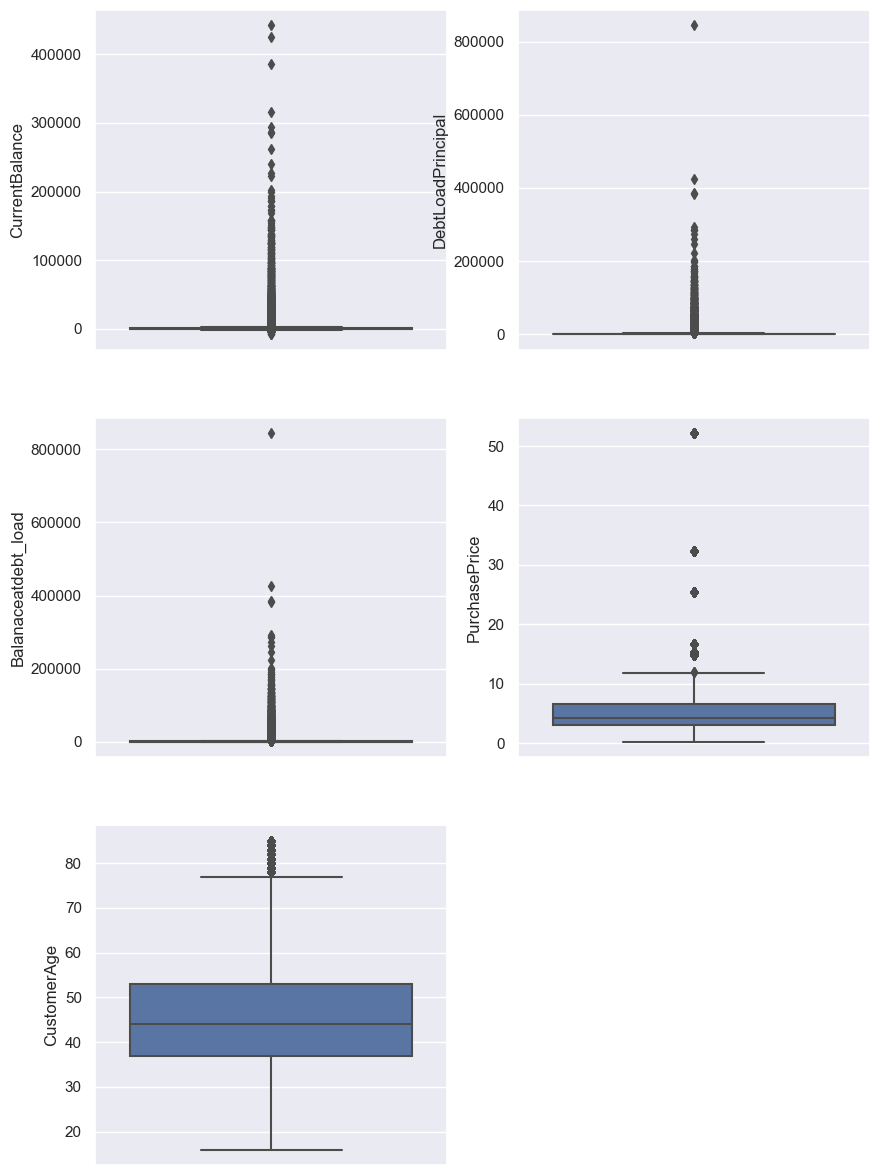

In [78]:
plt.figure(figsize=(10,15))
plt.subplot(3,2,1)
sns.boxplot(y=first_copy['CurrentBalance'])
plt.subplot(3,2,2)
sns.boxplot(y=first_copy['DebtLoadPrincipal'])
plt.subplot(3,2,3)
sns.boxplot(y=first_copy['Balanaceatdebt_load'])
plt.subplot(3,2,4)
sns.boxplot(y=first_copy['PurchasePrice'])
plt.subplot(3,2,5)
sns.boxplot(y=first_copy['CustomerAge'])
plt.show()

In [79]:
def outlier_treatment(column):
    
    q_3=first_copy[column].quantile(0.75)
    q_1=first_copy[column].quantile(0.25)
    IQR=q_3-q_1
    upper_limit=q_3+(1.5*IQR)
    lower_limit=q_1-(1.5*IQR)
    first_copy[column]=np.where(first_copy[column]>upper_limit,upper_limit
                              ,np.where(first_copy[column]<lower_limit,lower_limit,
                                       first_copy[column]))

In [80]:
for i in true_numeric:
    outlier_treatment(i)

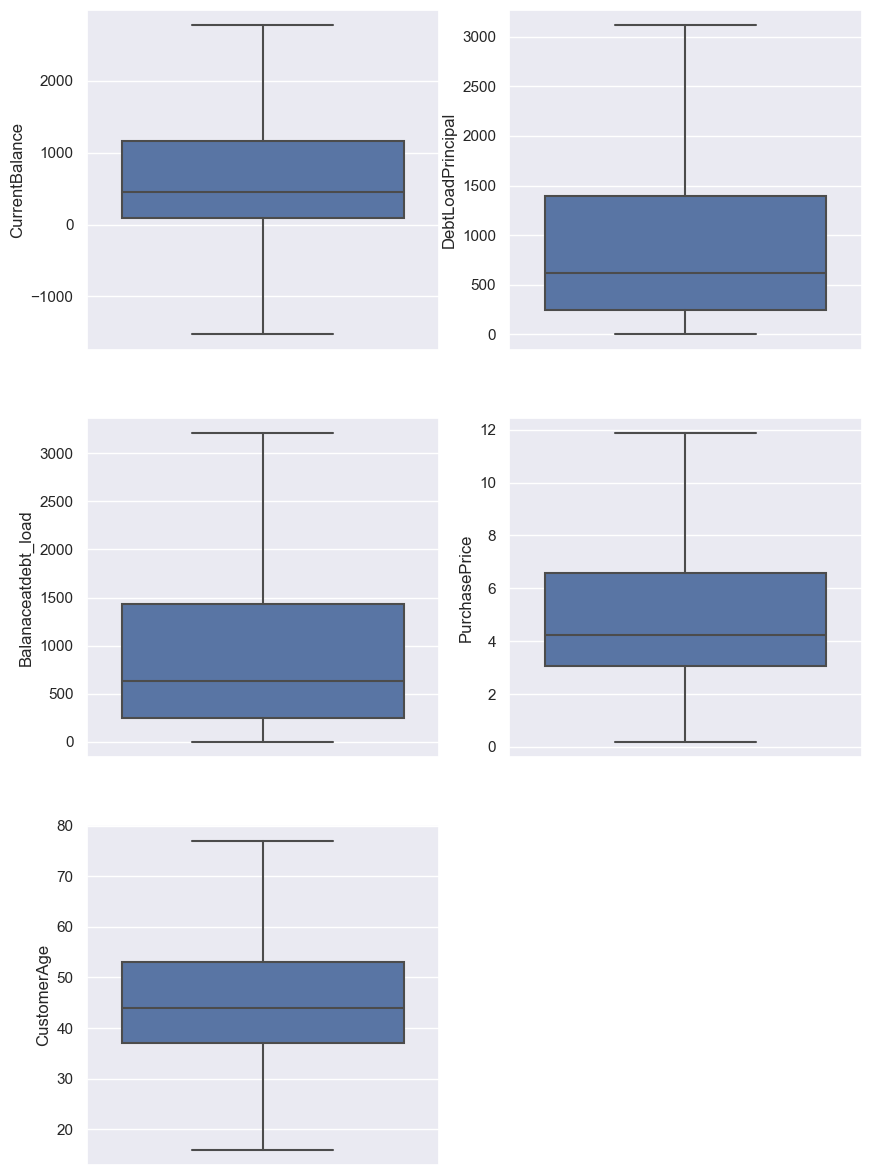

In [81]:
# Outlier Handled
plt.figure(figsize=(10,15))
plt.subplot(3,2,1)
sns.boxplot(y=first_copy['CurrentBalance'])
plt.subplot(3,2,2)
sns.boxplot(y=first_copy['DebtLoadPrincipal'])
plt.subplot(3,2,3)
sns.boxplot(y=first_copy['Balanaceatdebt_load'])
plt.subplot(3,2,4)
sns.boxplot(y=first_copy['PurchasePrice'])
plt.subplot(3,2,5)
sns.boxplot(y=first_copy['CustomerAge'])
plt.show()

In [82]:
# taking a copy for future use
third_copy=first_copy.copy()

## Splitting Dependent and Independent variables

In [83]:
y=first_copy['IsStatBarred_Y']
print("shape of y :",y.shape)

shape of y : (406423,)


In [84]:
x=first_copy.drop(["IsStatBarred_Y"],axis=1)
print("shape of x :",x.shape)

shape of x : (406423, 24)


In [85]:
y.value_counts()

1    284548
0    121875
Name: IsStatBarred_Y, dtype: int64

In [86]:
(121875*2)<=284548

True

In [87]:
# There is class imbalance. Hence applying oversampling to balance them.

s=SMOTE()
x_with_smote,y_with_smote=s.fit_resample(x,y)

In [88]:
y_with_smote.value_counts()

0    284548
1    284548
Name: IsStatBarred_Y, dtype: int64

In [89]:
print(x_with_smote.shape,y_with_smote.shape)

(569096, 24) (569096,)


## Splitting train and test data

In [90]:
x_train,x_test,y_train,y_test = train_test_split(x_with_smote, 
                                                 y_with_smote,
                                                 test_size=0.2, 
                                                random_state=35,
                                                 stratify=y_with_smote)

In [91]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(455276, 24) (113820, 24) (455276,) (113820,)


## Feature scaling

In [92]:
sc=StandardScaler()
for i in true_numeric:
    x_train[i] = sc.fit_transform(x_train[[i]])
    x_test[i] = sc.transform(x_test[[i]])


In [93]:
x_train.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CustomerAge,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,...,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1,NumLiableParties_1.0
530440,-0.802709,-1.013267,-1.010432,-0.795632,-0.539549,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,1
88705,-0.113637,-0.414639,-0.432467,-0.864338,-0.181738,0,1,0,0,0,...,1,0,1,0,0,0,1,1,0,1
68964,0.193660,-0.137965,-0.165343,-0.864338,0.476900,0,1,0,0,0,...,1,0,1,0,0,0,1,1,0,1
198979,2.188965,1.992551,1.981352,2.012460,1.382527,0,1,0,0,1,...,0,0,1,0,0,1,0,1,0,1
525543,-0.802709,-1.022405,-1.019254,-0.433567,-1.395640,0,1,0,0,1,...,0,0,0,0,0,0,1,1,0,1


In [94]:
x_test.head()

,CurrentBalance,DebtLoadPrincipal,Balanaceatdebt_load,PurchasePrice,CustomerAge,IsLegal_Y,InBankruptcy_N,ProductOrDebtType_Credit Cards,ProductOrDebtType_Finance Company - Other,ProductOrDebtType_Other,...,CollectionStatus_PASSIVE,CollectionStatus_UNDER_ARRANGEMENT,NumPhones_0,NumPhones_1,NumPhones_2,NumAddresses_0,NumAddresses_1,NumEmails_0,NumEmails_1,NumLiableParties_1.0
44641,-0.775118,-1.010203,-1.007474,-0.864338,2.617473,0,1,0,0,0,...,1,0,1,0,0,0,1,1,0,1
109450,-0.396842,-0.669623,-0.678649,-0.864338,-0.264067,0,1,0,0,0,...,1,0,1,0,0,0,1,1,0,1
496921,0.057649,-0.330843,-0.351564,-0.564671,0.825249,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
151656,0.120769,-0.371967,-0.228705,-0.156376,1.711846,0,1,0,0,1,...,1,0,1,0,0,1,0,1,0,1
376712,0.259478,-0.165645,-0.192068,-0.564671,-0.922705,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,1


In [95]:
# Checking p- values
log_reg_sm = sm.Logit(y_train.astype(float),x_train.astype(float)).fit()
log_reg_sm.summary()

Optimization terminated successfully.
         Current function value: 0.158264
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         IsStatBarred_Y   No. Observations:               455276
Model:                          Logit   Df Residuals:                   455252
Method:                           MLE   Df Model:                           23
Date:                Sat, 11 May 2024   Pseudo R-squ.:                  0.7717
Time:                        19:32:27   Log-Likelihood:                -72054.
converged:                       True   LL-Null:                   -3.1557e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
CurrentBalance                                0.9571      0.022     43.450      0.000       0.914       1.000
DebtLoadPrincipal                            -7.4185      0.140    -52.961      0.000      -7.693      -7.144
Balanaceatdebt_load                           6.2701      0.137     45.645      0.000       6.001       6.539
PurchasePrice                                -0.0036      0.009     -0.384      0.701      -0.022       0.015
CustomerAge                                   0.0106      0.008      1.377      0.168      -0.004       0.026
IsLegal_Y                                     1.1179      0.039     28.616      0.000       1.041       1.194
InBankruptcy_N                               -1.9395      0.030    -65.452      0.000      -1.998      -1.881
ProductOrDebtType_Credit Cards                2.3806      0.030     79.673      0.000       2.322       2.439
ProductOrDebtType_Finance Company - Other    -0.4026      0.023    -17.198      0.000      -0.448      -0.357
ProductOrDebtType_Other                       2.8494      0.031     91.124      0.000       2.788       2.911
ProductOrDebtType_Utilities/Telco - Other     3.0309      0.021    145.598      0.000       2.990       3.072
CollectionStatus_ACTIVE                       2.3146      0.033     70.138      0.000       2.250       2.379
CollectionStatus_CLOSED                      -1.9382      0.036    -54.312      0.000      -2.008      -1.868
CollectionStatus_PAID_IN_FULL                -4.7962      0.051    -94.603      0.000      -4.896      -4.697
CollectionStatus_PASSIVE                      3.8240      0.039     98.178      0.000       3.748       3.900
CollectionStatus_UNDER_ARRANGEMENT           -2.1423      0.170    -12.609      0.000      -2.475      -1.809
NumPhones_0                                   1.8122      0.030     61.356      0.000       1.754       1.870
NumPhones_1                                   0.9872      0.031     31.987      0.000       0.927       1.048
NumPhones_2                                   0.5185      0.041     12.619      0.000       0.438       0.599
NumAddresses_0                                1.0738      0.027     39.682      0.000       1.021       1.127
NumAddresses_1                                0.2753      0.024     11.434      0.000       0.228       0.323
NumEmails_0                                   1.4743      0.030     49.831      0.000       1.416       1.532
NumEmails_1                                   0.1058      0.030      3.480      0.001       0.046       0.165
NumLiableParties_1.0                         -3.9942      0.037   -108.037      0.000      -4.067      -3.922
=============================================================================================================
"""

In [96]:
# "PurchasePrice","CustomerAge" p values are more than 0.05 thus the 
# null hypothesis that "there is no significant relationship between the 
#feature and the target variable" is not rejected.Hence dropping them.
x_train_p_value_modified=x_train.drop(["PurchasePrice","CustomerAge"],axis=1)

In [97]:
x_test_p_value_modified=x_test.drop(["PurchasePrice","CustomerAge"],axis=1)

In [98]:
print(x_train.shape,x_test.shape,
      x_train_p_value_modified.shape,
      x_test_p_value_modified.shape)

(455276, 24) (113820, 24) (455276, 22) (113820, 22)


In [99]:
log_reg_sm = sm.Logit(y_train.astype(float),x_train_p_value_modified.astype(float)).fit()
log_reg_sm.summary()

Optimization terminated successfully.
         Current function value: 0.158266
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         IsStatBarred_Y   No. Observations:               455276
Model:                          Logit   Df Residuals:                   455254
Method:                           MLE   Df Model:                           21
Date:                Sat, 11 May 2024   Pseudo R-squ.:                  0.7717
Time:                        19:33:56   Log-Likelihood:                -72055.
converged:                       True   LL-Null:                   -3.1557e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
CurrentBalance                                0.9559      0.022     43.452      0.000       0.913       0.999
DebtLoadPrincipal                            -7.4286      0.139    -53.450      0.000      -7.701      -7.156
Balanaceatdebt_load                           6.2814      0.136     46.033      0.000       6.014       6.549
IsLegal_Y                                     1.1160      0.039     28.716      0.000       1.040       1.192
InBankruptcy_N                               -1.9385      0.030    -65.443      0.000      -1.997      -1.880
ProductOrDebtType_Credit Cards                2.3832      0.029     81.494      0.000       2.326       2.440
ProductOrDebtType_Finance Company - Other    -0.4057      0.021    -18.943      0.000      -0.448      -0.364
ProductOrDebtType_Other                       2.8496      0.031     91.757      0.000       2.789       2.910
ProductOrDebtType_Utilities/Telco - Other     3.0349      0.020    148.905      0.000       2.995       3.075
CollectionStatus_ACTIVE                       2.3108      0.033     70.275      0.000       2.246       2.375
CollectionStatus_CLOSED                      -1.9382      0.036    -54.330      0.000      -2.008      -1.868
CollectionStatus_PAID_IN_FULL                -4.7953      0.051    -94.608      0.000      -4.895      -4.696
CollectionStatus_PASSIVE                      3.8241      0.039     98.194      0.000       3.748       3.900
CollectionStatus_UNDER_ARRANGEMENT           -2.1418      0.170    -12.609      0.000      -2.475      -1.809
NumPhones_0                                   1.8121      0.030     61.361      0.000       1.754       1.870
NumPhones_1                                   0.9868      0.031     31.985      0.000       0.926       1.047
NumPhones_2                                   0.5188      0.041     12.634      0.000       0.438       0.599
NumAddresses_0                                1.0741      0.027     39.694      0.000       1.021       1.127
NumAddresses_1                                0.2759      0.024     11.462      0.000       0.229       0.323
NumEmails_0                                   1.4770      0.030     50.022      0.000       1.419       1.535
NumEmails_1                                   0.1049      0.030      3.452      0.001       0.045       0.165
NumLiableParties_1.0                         -3.9971      0.037   -108.282      0.000      -4.069      -3.925
=============================================================================================================
"""

## Stochastic Gradient Classifier model

In [100]:
sgd=SGDClassifier(loss='log')
sgd.fit(x_train_p_value_modified,y_train)

SGDClassifier(loss='log')

In [101]:
interpretation=pd.DataFrame({"Feature":x_train_p_value_modified.columns,
              "Coefficient_value":sgd.coef_.reshape(22,)})

In [102]:
interpretation["ODDS"]=np.exp(interpretation["Coefficient_value"])
interpretation

,Feature,Coefficient_value,ODDS
0,CurrentBalance,0.961315,2.615134
1,DebtLoadPrincipal,-3.084614,0.045748
2,Balanaceatdebt_load,1.921084,6.828357
3,IsLegal_Y,0.993201,2.699862
4,InBankruptcy_N,0.014899,1.015010
5,ProductOrDebtType_Credit Cards,2.525431,12.496276
6,ProductOrDebtType_Finance Company - Other,-0.215347,0.806262
7,ProductOrDebtType_Other,2.996550,20.016359
8,ProductOrDebtType_Utilities/Telco - Other,3.124731,22.753781
9,CollectionStatus_ACTIVE,3.957422,52.322288


In [148]:
interpretation=interpretation.sort_values(by=['ODDS'])
interpretation

,Feature,Coefficient_value,ODDS
1,DebtLoadPrincipal,-3.084614,0.045748
11,CollectionStatus_PAID_IN_FULL,-2.855450,0.057530
21,NumLiableParties_1.0,-0.573815,0.563372
6,ProductOrDebtType_Finance Company - Other,-0.215347,0.806262
13,CollectionStatus_UNDER_ARRANGEMENT,-0.043480,0.957452
4,InBankruptcy_N,0.014899,1.015010
10,CollectionStatus_CLOSED,0.307987,1.360683
18,NumAddresses_1,0.587567,1.799604
0,CurrentBalance,0.961315,2.615134
3,IsLegal_Y,0.993201,2.699862


In [151]:
Top_5_features=interpretation[-1:-6:-1]["Feature"].to_list()
print("The top 5 features :",Top_5_features)

The top 5 features : ['CollectionStatus_PASSIVE', 'CollectionStatus_ACTIVE', 'ProductOrDebtType_Utilities/Telco - Other', 'ProductOrDebtType_Other', 'NumEmails_0']


## Interpreting the odds value
Lets take an example of a categorical feature,say,"NumAddresses_1".
Holding all the other features at a fixed value,the odds of getting statue barred(=1) for the record having only one address (NumAddresses_1 =1) 
over the odds of getting statue barred(=1) for the record having more than one address (NumAddresses_1 =0) is exp(0.587567)= 1.799604 .
In terms of percent change,the odds for the record having only one address are 79.9% higher than the odds for the record having more than one address.

Another example for a continuous feature,say,CurrentBalance
Holding all the other features at a fixed value, we will see 161.5% increase in the odds of getting statue barred(=1) for a one-unit increase in CurrentBalance since exp(0.961315)= 2.615134.


In [103]:
sgd_predictions_train=sgd.predict(x_train_p_value_modified)
sgd_predictions_test=sgd.predict(x_test_p_value_modified)
print('Train data accuracy :',accuracy_score(y_train,sgd_predictions_train))
print('Validation data accuracy :',accuracy_score(y_test,sgd_predictions_test))

Train data accuracy : 0.9474977815654679
Validation data accuracy : 0.9462660340889123


In [104]:
accuracy_cross_val=cross_val_score(sgd,x_train_p_value_modified,y_train,cv=10)
print("Cross Validation Accuracy scores : ", accuracy_cross_val)
print('\n*****\n')
print("Mean of Cross Validation Accuracy scores : ",accuracy_cross_val.mean())
print('\n*****\n')
print("Max of Cross Validation Accuracy scores : ",accuracy_cross_val.max())
print('\n*****\n')
print("Min of Cross Validation Accuracy scores : ",accuracy_cross_val.min())

Cross Validation Accuracy scores :  [0.94695572 0.94598928 0.94587946 0.94638464 0.94831752 0.94697768
 0.94675687 0.94583434 0.94585631 0.94392339]

*****

Mean of Cross Validation Accuracy scores :  0.9462875205827199

*****

Max of Cross Validation Accuracy scores :  0.9483175188894746

*****

Min of Cross Validation Accuracy scores :  0.9439233861225207


In [105]:
accuracy_cross_val=cross_val_score(sgd,x_test_p_value_modified,y_test,cv=10)
print("Cross Validation Accuracy scores : ", accuracy_cross_val)
print('\n*****\n')
print("Mean of Cross Validation Accuracy scores : ",accuracy_cross_val.mean())
print('\n*****\n')
print("Max of Cross Validation Accuracy scores : ",accuracy_cross_val.max())
print('\n*****\n')
print("Min of Cross Validation Accuracy scores : ",accuracy_cross_val.min())

Cross Validation Accuracy scores :  [0.94552803 0.9447373  0.94798805 0.94359515 0.94675804 0.9447373
 0.94913021 0.94289229 0.9441223  0.94175013]

*****

Mean of Cross Validation Accuracy scores :  0.9451238798102267

*****

Max of Cross Validation Accuracy scores :  0.9491302055877702

*****

Min of Cross Validation Accuracy scores :  0.9417501317870322


In [106]:
print(classification_report(y_train,sgd_predictions_train))
print("\n")
print(accuracy_score(y_train,sgd_predictions_train))
print("\n")
print(confusion_matrix(y_train,sgd_predictions_train))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95    227638
           1       0.95      0.94      0.95    227638

    accuracy                           0.95    455276
   macro avg       0.95      0.95      0.95    455276
weighted avg       0.95      0.95      0.95    455276



0.9474977815654679


[[216507  11131]
 [ 12772 214866]]


In [107]:
print(classification_report(y_test,sgd_predictions_test))
print("\n")
print(accuracy_score(y_test,sgd_predictions_test))
print("\n")
print(confusion_matrix(y_test,sgd_predictions_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     56910
           1       0.95      0.94      0.95     56910

    accuracy                           0.95    113820
   macro avg       0.95      0.95      0.95    113820
weighted avg       0.95      0.95      0.95    113820



0.9462660340889123


[[54071  2839]
 [ 3277 53633]]


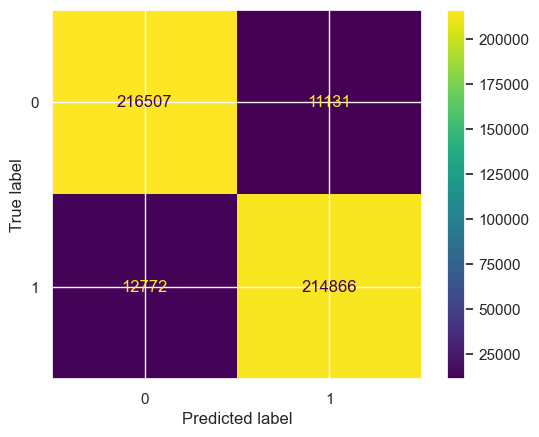

In [108]:
# Confusion matrix of train data
confusion_matrix_train= ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train,sgd_predictions_train),
                              display_labels=sgd.classes_)
confusion_matrix_train.plot()
plt.show()

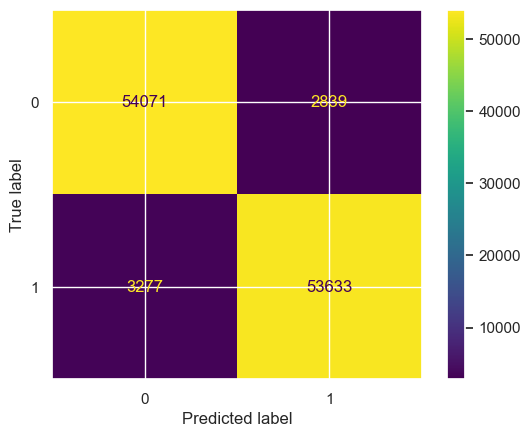

In [110]:
# Confusion matrix of test data
confusion_matrix_train= ConfusionMa
confusion_matrix_test= ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,sgd_predictions_test),
                              display_labels=sgd.classes_)
confusion_matrix_test.plot()
plt.show()

In [111]:
print("Train Data ROC_AUC score :",roc_auc_score(y_train,sgd_predictions_train))
print("\n")
print("Test Data ROC_AUC score :",roc_auc_score(y_test,sgd_predictions_test))

Train Data ROC_AUC score : 0.9474977815654679


Test Data ROC_AUC score : 0.9462660340889123


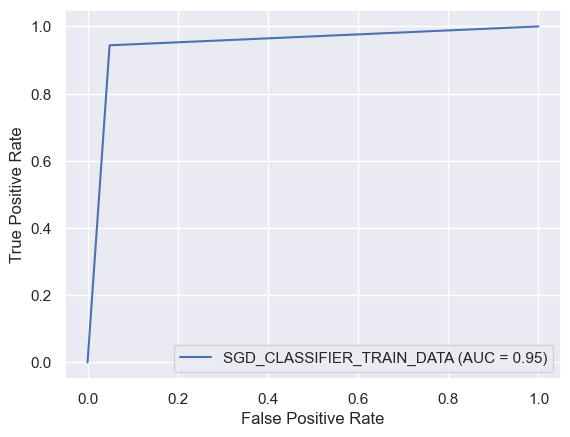

In [112]:
# Plotting  ROC-AUC curve for train data
fpr, tpr, thresholds = metrics.roc_curve(y_train,sgd_predictions_train)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='SGD_CLASSIFIER_TRAIN_DATA')
display.plot()
plt.show()

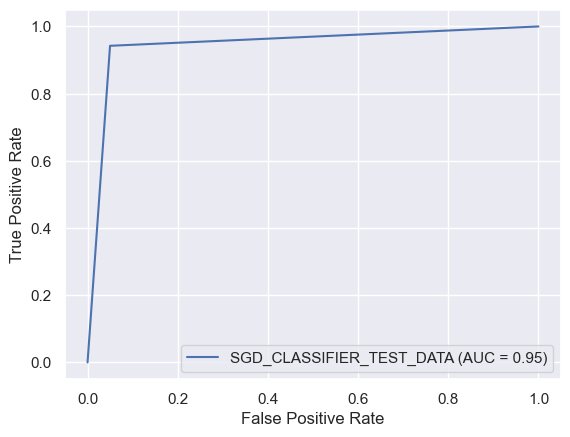

In [113]:
# Plotting  ROC-AUC curve for test data
fpr, tpr, thresholds = metrics.roc_curve(y_test,sgd_predictions_test)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='SGD_CLASSIFIER_TEST_DATA')
display.plot()
plt.show()

## RandomForest model

### Splitting train and test data

In [114]:
x_train_rf,x_test_rf,y_train_rf,y_test_rf = train_test_split(x_with_smote, 
                                                 y_with_smote,
                                                 test_size=0.2, 
                                                random_state=35,
                                                 stratify=y_with_smote)

In [115]:
print(x_train_rf.shape,x_test_rf.shape,y_train_rf.shape,y_test_rf.shape)

(455276, 24) (113820, 24) (455276,) (113820,)


In [116]:
clf = RandomForestClassifier()
clf.fit(x_train_rf,y_train_rf)

RandomForestClassifier()

In [117]:
Feature_importances=pd.DataFrame({"Feature":x_train_rf.columns,
              "RF_importance_value":clf.feature_importances_})
Feature_importances=Feature_importances.sort_values(by=['RF_importance_value'])

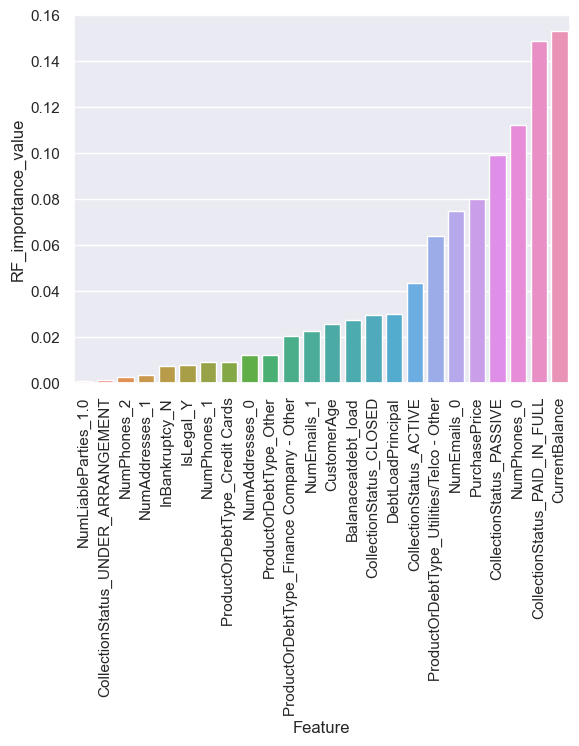

In [118]:
# Plotting the feature importances
sns.barplot(x='Feature' ,y ='RF_importance_value',data = Feature_importances)
plt.xticks(rotation=90)
plt.show()

In [119]:
Feature_importances

,Feature,RF_importance_value
23,NumLiableParties_1.0,0.001036
15,CollectionStatus_UNDER_ARRANGEMENT,0.001475
18,NumPhones_2,0.002787
20,NumAddresses_1,0.003723
6,InBankruptcy_N,0.007596
5,IsLegal_Y,0.008097
17,NumPhones_1,0.009354
7,ProductOrDebtType_Credit Cards,0.009404
19,NumAddresses_0,0.012175
9,ProductOrDebtType_Other,0.012356


In [147]:
top_5_features=Feature_importances[-1:-6:-1]['Feature'].tolist()
print("The top most important features :",top_5_features)

The top most important features : ['CurrentBalance', 'CollectionStatus_PAID_IN_FULL', 'NumPhones_0', 'CollectionStatus_PASSIVE', 'PurchasePrice']


In [121]:
rf_train_predictions=clf.predict(x_train_rf)
rf_test_predictions=clf.predict(x_test_rf)

In [122]:
print("Train data accuracy :",accuracy_score(rf_train_predictions,y_train_rf))
print("Test data accuracy :",accuracy_score(rf_test_predictions,y_test_rf))

Train data accuracy : 0.9972478232983948
Test data accuracy : 0.9727112985415568


In [123]:
print(classification_report(y_train_rf,rf_train_predictions))
print("\n")
print(accuracy_score(y_train_rf,rf_train_predictions))
print("\n")
print(confusion_matrix(y_train_rf,rf_train_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227638
           1       1.00      1.00      1.00    227638

    accuracy                           1.00    455276
   macro avg       1.00      1.00      1.00    455276
weighted avg       1.00      1.00      1.00    455276



0.9972478232983948


[[227115    523]
 [   730 226908]]


In [124]:
print(classification_report(y_test_rf,rf_test_predictions))
print("\n")
print(accuracy_score(y_test_rf,rf_test_predictions))
print("\n")
print(confusion_matrix(y_test_rf,rf_test_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     56910
           1       0.97      0.97      0.97     56910

    accuracy                           0.97    113820
   macro avg       0.97      0.97      0.97    113820
weighted avg       0.97      0.97      0.97    113820



0.9727112985415568


[[55371  1539]
 [ 1567 55343]]


In [125]:
accuracy_cross_val=cross_val_score(clf,x_train_rf,y_train_rf,cv=10)
print("Cross Validation Accuracy scores : ", accuracy_cross_val)
print('\n*****\n')
print("Mean of Cross Validation Accuracy scores : ",accuracy_cross_val.mean())
print('\n*****\n')
print("Max of Cross Validation Accuracy scores : ",accuracy_cross_val.max())
print('\n*****\n')
print("Min of Cross Validation Accuracy scores : ",accuracy_cross_val.min())

Cross Validation Accuracy scores :  [0.97208311 0.9725224  0.9735767  0.97241258 0.97342295 0.97324723
 0.97381773 0.97256573 0.97256573 0.97322468]

*****

Mean of Cross Validation Accuracy scores :  0.9729438854636155

*****

Max of Cross Validation Accuracy scores :  0.9738177345311574

*****

Min of Cross Validation Accuracy scores :  0.9720831136882797


In [126]:
accuracy_cross_val=cross_val_score(clf,x_test_rf,y_test_rf,cv=10)
print("Cross Validation Accuracy scores : ", accuracy_cross_val)
print('\n*****\n')
print("Mean of Cross Validation Accuracy scores : ",accuracy_cross_val.mean())
print('\n*****\n')
print("Max of Cross Validation Accuracy scores : ",accuracy_cross_val.max())
print('\n*****\n')
print("Min of Cross Validation Accuracy scores : ",accuracy_cross_val.min())

Cross Validation Accuracy scores :  [0.96898612 0.96661395 0.97083114 0.96845897 0.96740467 0.96555966
 0.96977684 0.96749253 0.96845897 0.96617466]

*****

Mean of Cross Validation Accuracy scores :  0.9679757511860834

*****

Max of Cross Validation Accuracy scores :  0.9708311368827974

*****

Min of Cross Validation Accuracy scores :  0.965559655596556


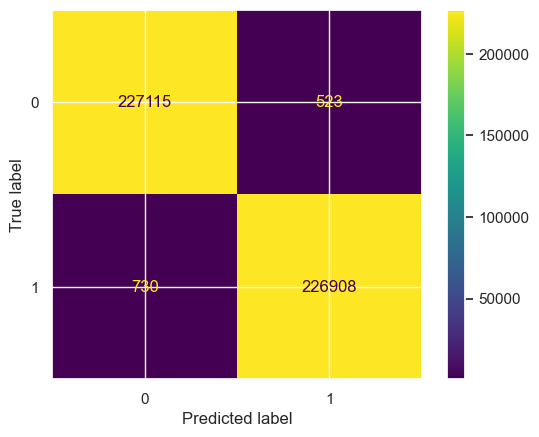

In [127]:
# Confusion matrix for train data
confusion_matrix_train_rf= ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_rf,rf_train_predictions),
                              display_labels=clf.classes_)
confusion_matrix_train_rf.plot()
plt.show()

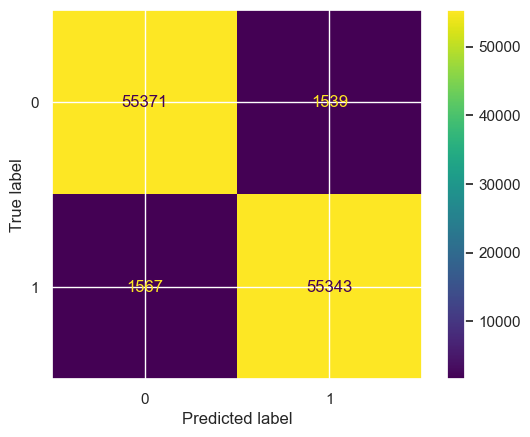

In [128]:
# Confusion matrix for test data
confusion_matrix_test_rf= ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_rf,rf_test_predictions),
                              display_labels=clf.classes_)
confusion_matrix_test_rf.plot()
plt.show()

In [129]:
print("Train Data ROC_AUC score :",roc_auc_score(y_train_rf,rf_train_predictions))
print("\n")
print("Test Data ROC_AUC score :",roc_auc_score(y_test_rf,rf_test_predictions))

Train Data ROC_AUC score : 0.9972478232983948


Test Data ROC_AUC score : 0.9727112985415568


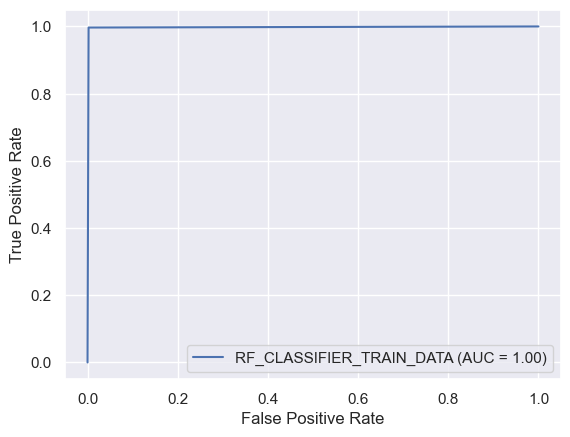

In [130]:
# ROC-AUC curve for train data
fpr, tpr, thresholds = metrics.roc_curve(y_train_rf,rf_train_predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='RF_CLASSIFIER_TRAIN_DATA')
display.plot()
plt.show()

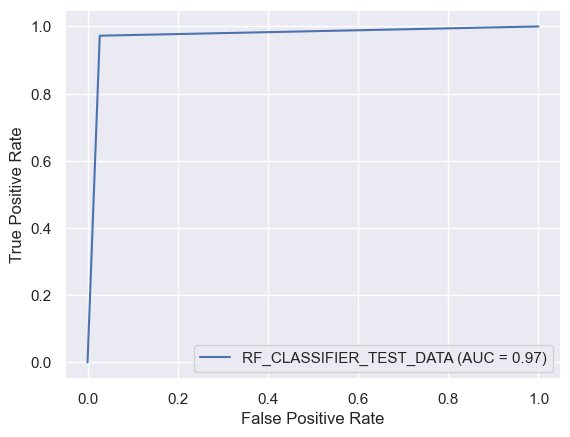

In [131]:
# ROC-AUC curve for test data
fpr, tpr, thresholds = metrics.roc_curve(y_test_rf,rf_test_predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='RF_CLASSIFIER_TEST_DATA')
display.plot()
plt.show()

# Conclusion
1.Random Forest outperfomed SGD classifier.
2.Random Forest is preferred if the only concern is accuracy.
3.SGD is preferred if the need is to know how each feature affects the dependent variable.